In [26]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import networkx as nx
import osmnx as ox
import os
import pandas as pd
import numpy as np
import importlib
from tqdm import tqdm
from datetime import datetime
from bs4 import BeautifulSoup
from osgeo import gdal, osr
import copy
import re

import helper_functions.utils
import helper_functions.flood_utils
import helper_functions.plot_utils
import helper_functions.routing.driving
import helper_functions.routing.dryRouting
import helper_functions.routing.floodedRouting
import helper_functions.routing.publicTransit

importlib.reload(helper_functions.utils)
importlib.reload(helper_functions.flood_utils)
importlib.reload(helper_functions.plot_utils)
importlib.reload(helper_functions.routing.driving)
importlib.reload(helper_functions.routing.dryRouting)
importlib.reload(helper_functions.routing.floodedRouting)
importlib.reload(helper_functions.routing.publicTransit)

import helper_functions.utils as utils
import helper_functions.flood_utils as flood_utils
import helper_functions.plot_utils as plot_utils
import helper_functions.routing.driving as driving
import helper_functions.routing.dryRouting as dryRouting
import helper_functions.routing.floodedRouting as floodedRouting
import helper_functions.routing.publicTransit as publicTransit

# Import data

### Road network

In [2]:
save_dir = os.path.join(os.getcwd(),"data")
filename = "SG_bus_network.graphml"
G_bus = ox.load_graphml(os.path.join(save_dir,filename))

save_dir = os.path.join(os.getcwd(),"data")
filename = "SG_car_network.graphml"
G_car = ox.load_graphml(os.path.join(save_dir,filename))

### Planning area

<class 'geopandas.geodataframe.GeoDataFrame'>


,Name,Description,geometry,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.93208 1.30555 0, 103.93208 1.3...",BEDOK,BD,N,EAST REGION,ER,5F00E6FF084F3364,20191223152014
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.72042 1.32824 0, 103.72003 1.3...",BOON LAY,BL,N,WEST REGION,WR,C96AED188C00B2FC,20191223152014
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.76408 1.37001 0, 103.76444 1.3...",BUKIT BATOK,BK,N,WEST REGION,WR,3BEC4C829160F28A,20191223152014
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.82361 1.26018 0, 103.82362 1.2...",BUKIT MERAH,BM,N,CENTRAL REGION,CR,4850795BB0B6A4F7,20191223152014
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.77445 1.39029 0, 103.77499 1.3...",BUKIT PANJANG,BP,N,WEST REGION,WR,656F87D23D6DAB02,20191223152014


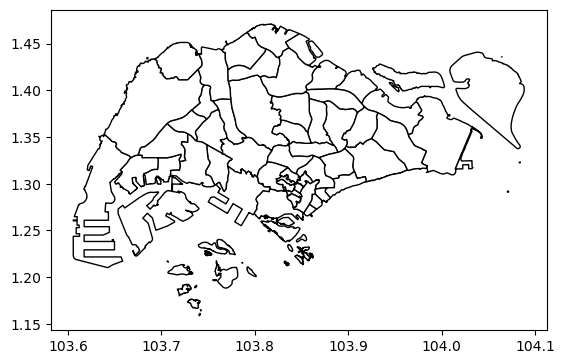

In [3]:
planningArea_noSea = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019PlanningAreaBoundaryNoSea.geojson")

def extract_html_tags(row):
    html_content = row["Description"]
    soup = BeautifulSoup(html_content,"html.parser")
    ths = soup.find_all('th')
    tds = soup.find_all('td')
    column_names = []
    column_values = []
    for th in ths:
        column_names.append(th.get_text())
    for td in tds:
        column_values.append(td.get_text())
    column_names = column_names[1:] # remove the first "Attribute"
    return pd.Series({k:v for k,v in zip(column_names,column_values)})
# column_names, _ = extract_html_tags(planningArea_noSea.iloc[0,1])
planningArea_shp = planningArea_noSea.join(planningArea_noSea.apply(extract_html_tags,axis=1))
print(type(planningArea_shp))
planningArea_shp.plot(fc='white',ec='k')
planningArea_shp.head()

### Drainage catchment

,Id,gridcode,geometry,drainage_catchment
0,1029,4,"POLYGON ((103.78385 1.37628, 103.78385 1.37801...",Woodlands
1,1727,9,"POLYGON ((103.90358 1.34541, 103.90139 1.34541...",Punggol
2,1751,2,"POLYGON ((103.65627 1.38031, 103.65646 1.38074...",Kranji
3,1837,5,"POLYGON ((103.86428 1.322, 103.86428 1.32207, ...",Kallang
4,2106,11,"POLYGON ((103.9156 1.30147, 103.91546 1.30147,...",Changi
5,2247,6,"POLYGON ((103.85983 1.29644, 103.85976 1.29644...",Bukit Timah
6,2334,7,"POLYGON ((103.86435 1.28825, 103.86018 1.28825...",Stamford Marina
7,2426,10,"POLYGON ((103.87418 1.28158, 103.87418 1.28165...",Geylang
8,2452,8,"POLYGON ((103.80456 1.30721, 103.80481 1.30715...",Singapore River
9,2528,7,"POLYGON ((103.84795 1.26391, 103.84795 1.26399...",Stamford Marina


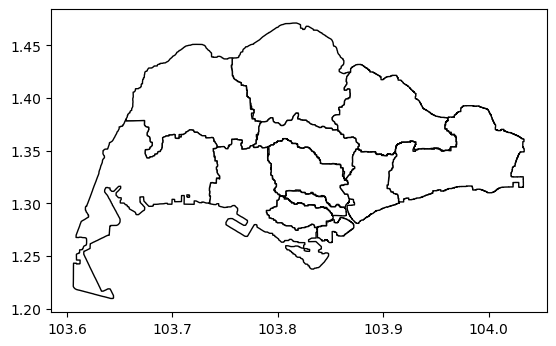

In [4]:
drainage_catchment_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Drains\SG_DrainageCatchment.shp")
drainage_catchment_shp['drainage_catchment'] = [flood_utils.grid_code_drainage_catchment()[i] for i in drainage_catchment_shp['gridcode'].to_list()]
drainage_catchment_shp.plot(fc='white',ec='k')
drainage_catchment_shp

### Historical floods

In [5]:
historical_floods = pd.read_csv(r"Flood_Weather_Data\precipitation_levels_during_flood_events.csv")
print(historical_floods.dtypes)
print("Length of df: ",len(historical_floods.index))
print("Number of unique flood events: ",len(historical_floods['matched_location'].unique()))
historical_floods.head()

flooded_location                  object
responses_found                    int64
matched_location                  object
latitude                         float64
longitude                        float64
closest_weather_stn               object
mean_pr                          float64
daily rainfall total (mm)        float64
highest 30 min rainfall (mm)     float64
highest 60 min rainfall (mm)     float64
highest 120 min rainfall (mm)    float64
drainage_catchment                object
time                              object
dtype: object
Length of df:  220
Number of unique flood events:  144


,flooded_location,responses_found,matched_location,latitude,longitude,closest_weather_stn,mean_pr,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),drainage_catchment,time
0,Yishun MRT,9,ATM DBS YISHUN MRT STATION,1.429525,103.834995,Yishun,17.395082,45.0,40.8,44.0,44.2,Woodlands,2014-03-20
1,2 KAKI BUKIT ROAD 3,1,2 KAKI BUKIT ROAD 3 SINGAPORE 417817,1.337334,103.901943,Tai Seng,7.993548,25.0,21.0,25.0,25.0,Geylang,2014-04-04
2,PSC Building,1,PSC BUILDING,1.328863,103.706189,Boon Lay (West),14.574603,89.5,49.5,83.0,89.0,Jurong,2014-04-23
3,21229 (bus stop),1,21229 (BUS STOP),1.342064,103.716020,Jurong (North),14.574603,65.4,51.6,63.8,65.4,Jurong,2014-04-23
4,Tengah Flyover,1,TENGAH FLYOVER,1.363822,103.707043,Jurong (North),22.195238,92.6,50.2,78.4,92.2,Kranji,2014-05-16


,matched_location,latitude,longitude,count,color
0,21229 (BUS STOP),1.342064,103.716020,13,#800000ff
1,DUNEARN ROAD / WHITLEY ROAD - ERP(44),1.321188,103.825058,6,#36ffc1ff
2,PSC BUILDING,1.328863,103.706189,6,#36ffc1ff
3,JURONG EAST STREET 32,1.346948,103.733825,4,#0080ffff
4,63139 (BUS STOP),1.361202,103.891412,4,#0080ffff
...,...,...,...,...,...
139,THE GLADES,1.327081,103.947772,1,#000080ff
140,TOH TUCK AVENUE,1.330540,103.758726,1,#000080ff
141,TUAS UNDERPASS,1.321705,103.663691,1,#000080ff
142,UNIVERSITY FLYOVER,1.303247,103.771674,1,#000080ff


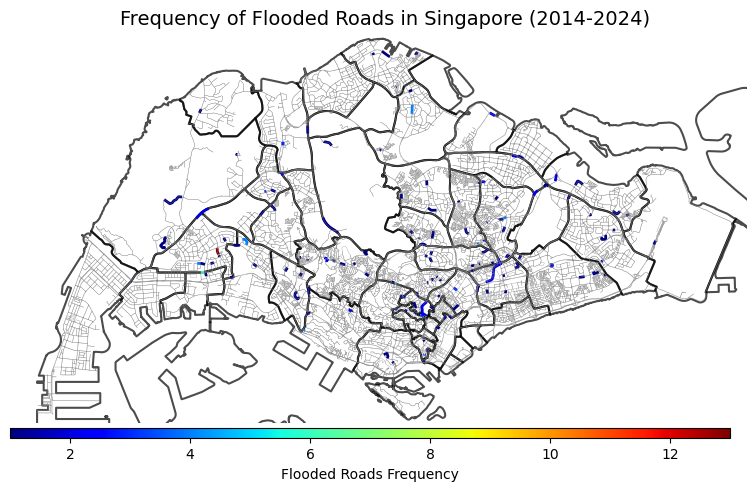

In [25]:
def plot_flooded_roads_frequency(G, historical_floods,cmap='plasma',ax=None,colorbar_label='Flooded Roads Frequency'):
    """ 
    Plot the frequency of flooded roads in the network graph G.
    Args:
        G (networkx.Graph): The network graph.
        historical_floods (pandas.DataFrame): DataFrame containing historical flood data.
    """
    # calculate the frequency of flooded roads based on matched_location
    flooded_roads_frequency = historical_floods[['matched_location','latitude','longitude']].value_counts().reset_index()
    
    # get unique colours based on unique max speed, colors start and end must be from 0 to 1
    max_freq = flooded_roads_frequency['count'].max()
    min_freq = flooded_roads_frequency['count'].min()
    # iso_colors = ox.plot.get_colors(n=max_freq, cmap=cmap, start=min_freq/max_freq, stop=1)
    # define cbar 
    cbar = plot_utils.get_colorbar(vmin=min_freq,vmax=max_freq,cmap=cmap,plot=False)
    # add an additional column to flooded_roads_frequency for the color that matches the frequency
    flooded_roads_frequency['color'] = flooded_roads_frequency['count'].apply(lambda x: mpl.colors.rgb2hex(cbar.to_rgba(x),keep_alpha=True))

    # get closest edges to the flooded roads
    flooded_edges = ox.distance.nearest_edges(G,X = flooded_roads_frequency['longitude'], Y = flooded_roads_frequency['latitude'])
    flooded_edges = list(flooded_edges)

    # get the flooded edges from the graph
    color_map = {e: color for color, e in zip(flooded_roads_frequency['color'], flooded_edges)}
    ec = [color_map[e] if e in flooded_edges else "grey" for e in G.edges(keys=True) ]
    ew = [2 if e in flooded_edges else 0.2 for e in G.edges(keys=True) ]
    fig, ax = ox.plot_graph(
        G,
        node_size=0,
        edge_color = ec,
        edge_linewidth=ew,
        ax=ax,
        bgcolor='white',
        show = False,
        close = False
    )

    # plot colorbar
    # create cax to add colorbar to the figure
    fig.subplots_adjust(bottom=0.1)
    cbar_ax = fig.add_axes([0.2, 0.07, 0.6, 0.02]) # left, bottom, width, height
    fig.colorbar(cbar, cax=cbar_ax, orientation="horizontal", label=colorbar_label)
    
    # historical_floods[['matched_location','latitude','longitude']].groupby(['matched_location']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).head(10)
    return flooded_roads_frequency

ax = planningArea_shp.plot(fc="none", ec="black", lw=1.5, alpha=0.7, figsize=(12, 5))
ax.set_title("Frequency of Flooded Roads in Singapore (2014-2024)", fontsize=14)
plot_flooded_roads_frequency(G_bus, historical_floods,cmap='jet',ax=ax,colorbar_label='Flooded Roads Frequency')

### Spatial travel patterns
- Relevant for estimating vehicle traffic volume (car analysis)

In [7]:
spatialTravelPatterns = pd.read_csv(r"data\SpatialTravelPatterns.csv")
spatialTravelPatterns = spatialTravelPatterns.rename(columns={'Planning Area of Workplace':'end_PLN_AREA_N','Region':'start_REGION_N'})
spatialTravelPatterns['end_PLN_AREA_N'] = spatialTravelPatterns['end_PLN_AREA_N'].apply(lambda x: x.upper().strip())
spatialTravelPatterns['start_REGION_N'] = spatialTravelPatterns['start_REGION_N'].apply(lambda x: f"{x.upper()} REGION")
# skip the last 3 rows due to no data or combined data
spatialTravelPatterns = spatialTravelPatterns.iloc[:-3,:]
print("missing planning areas: ",set(planningArea_shp['PLN_AREA_N'])^set(spatialTravelPatterns['end_PLN_AREA_N']))
print("missing regions: ",set(planningArea_shp['REGION_N'])^set(spatialTravelPatterns['start_REGION_N']))
spatialTravelPatterns.head()

missing planning areas:  {'STRAITS VIEW', 'MARINA SOUTH', 'MANDAI', 'RIVER VALLEY', 'TENGAH', 'SIMPANG', 'CHANGI BAY', 'CENTRAL WATER CATCHMENT', 'NORTH-EASTERN ISLANDS', 'LIM CHU KANG', 'MARINA EAST', 'OTHER PLANNING AREAS OR OUTSIDE SINGAPORE', 'NO FIXED LOCATION FOR WORK', 'WORKS FROM HOME'}
missing regions:  set()


,end_PLN_AREA_N,start_REGION_N,Total,Combinations of MRT/LRT or Public Bus,Car/Taxi/Private Hire Car Only,Other Modes,No Transport Required
0,ANG MO KIO,CENTRAL REGION,7393,4385.0,2583.0,314.0,112.0
1,BEDOK,CENTRAL REGION,9637,5774.0,3027.0,703.0,132.0
2,BISHAN,CENTRAL REGION,7252,3553.0,1974.0,443.0,1282.0
3,BOON LAY,CENTRAL REGION,2252,975.0,1041.0,231.0,6.0
4,BUKIT BATOK,CENTRAL REGION,4954,2456.0,2155.0,250.0,93.0


### Bus origin destination trip volume
- Relevant for estimating trip volume for people travelling via public transport (bus analysis)

In [8]:
origin_destination_bus = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\origin_destination_bus\origin_destination_bus_202502.csv")
print("Length of OD bus: ", len(origin_destination_bus))

OD_hourly_avg = pd.read_csv(os.path.join(r"data","origin_destination_bus_202502.csv"))
# pad bus stop ids with zeros
OD_hourly_avg[['ORIGIN_PT_CODE','DESTINATION_PT_CODE']] = OD_hourly_avg[['ORIGIN_PT_CODE','DESTINATION_PT_CODE']].apply(lambda x: x.astype(str).str.pad(5,fillchar='0'))
print("Length of OD bus: ", len(OD_hourly_avg))
OD_hourly_avg.head()

Length of OD bus:  5574345
Length of OD bus:  231511


,ORIGIN_PT_CODE,DESTINATION_PT_CODE,count,mean,std,min,25%,50%,75%,max
0,01012,01112,3.0,56.333333,45.981880,7.0,35.5,64.0,81.0,98.0
1,01012,01113,3.0,56.333333,8.082904,49.0,52.0,55.0,60.0,65.0
2,01012,01121,3.0,28.000000,5.567764,23.0,25.0,27.0,30.5,34.0
3,01012,01211,3.0,22.333333,16.072751,4.0,16.5,29.0,31.5,34.0
4,01012,01311,3.0,51.666667,25.423087,24.0,40.5,57.0,65.5,74.0


### Proportion of car traffic flow from each region
- calculate traffic flow stats for each planning area

Length of maxTrafficVol:  42


,PLN_AREA_N,n_routes,min_traffic_volume,mean_traffic_volume,max_traffic_volume,sum_traffic_volume,end_PLN_AREA_N,CENTRAL REGION_prop,EAST REGION_prop,NORTH REGION_prop,NORTH-EAST REGION_prop,WEST REGION_prop,max_traffic_CENTRAL REGION,max_traffic_EAST REGION,max_traffic_NORTH REGION,max_traffic_NORTH-EAST REGION,max_traffic_WEST REGION
0,ANG MO KIO,1488.0,80.0,1678.822581,7814.0,104087.0,ANG MO KIO,0.193701,0.132508,0.160255,0.366179,0.147357,1513.577953,1035.420922,1252.232321,2861.324484,1151.444319
1,BEDOK,3380.0,52.0,1238.377551,6073.0,121361.0,BEDOK,0.181638,0.404860,0.068707,0.260966,0.083828,1103.088569,2458.717732,417.256826,1584.847105,509.089769
2,BISHAN,1086.0,98.0,932.772727,999.0,20521.0,BISHAN,0.245217,0.150932,0.119752,0.320248,0.163851,244.972174,150.780745,119.631801,319.928199,163.687081
3,BOON LAY,360.0,97.0,1246.523810,5173.0,26177.0,BOON LAY,0.177191,0.082723,0.089702,0.104170,0.546213,916.611574,427.928170,464.029106,538.872511,2825.558638
4,BUKIT BATOK,1022.0,9.0,1183.000000,5051.0,17745.0,BUKIT BATOK,0.193969,0.080468,0.109541,0.153105,0.462916,979.739424,406.444104,553.291359,773.334923,2338.190189


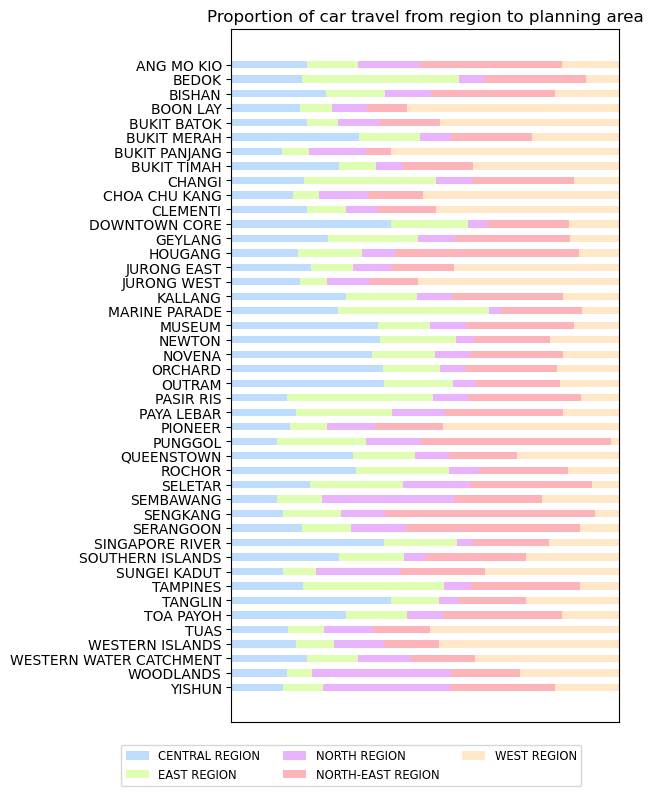

In [9]:
def get_car_traffic_flow_proportion(spatialTravelPatterns,planningArea,plot=True,ax=None,title=""):
    """ calculate proportion of travel from each region 
    Args:
        spatialTravelPatterns (pd.DataFrame): 
        planningArea (geopandas.DataFrame):
        plot (bool): If True, plot stacked barplot
        ax (mpl.Axes): if None, supply a new figure, else draw on supplied axes
        title (str): title for plot
    Returns:
        pd.DataFrame: proportion of Car/Taxi/Private Hire Car Only travelling from region to planning area
    """
    colors = {'EAST REGION':"#dffeb2","WEST REGION": "#ffe7c8","CENTRAL REGION":"#bedcfd",
                    'NORTH REGION':"#e9b3fd",'NORTH-EAST REGION':"#fdb3ba"}
    pivoted_df = spatialTravelPatterns.pivot(index='end_PLN_AREA_N',columns='start_REGION_N',values='Car/Taxi/Private Hire Car Only')
    pivoted_df['sum'] = pivoted_df.sum(axis=1)
    for region in pivoted_df.columns[:-1]:
        pivoted_df[f"{region}_prop"] = pivoted_df[region]/pivoted_df['sum']
    
    # select valid planning area rows
    intersection_pln = planningArea['PLN_AREA_N'][planningArea['PLN_AREA_N'].isin(pivoted_df.index)].sort_values().to_list()
    pivoted_df = pivoted_df.loc[intersection_pln,:]
    if plot:
        # y labels aka PLN_AREA_N
        labels = pivoted_df.index.to_list()
        category_names = pivoted_df.columns[-5:]
        category_colors = [colors[c.replace("_prop","")] for c in category_names]
        data = pivoted_df[category_names].values
        data_cum = data.cumsum(axis=1)
        if ax is None:
            fig, ax = plt.subplots(figsize=(5, 9))
        ax.invert_yaxis()
        ax.xaxis.set_visible(False)
        ax.set_xlim(0, np.sum(data, axis=1).max())

        for i, (colname, color) in enumerate(zip(category_names, category_colors)):
            widths = data[:, i]
            starts = data_cum[:, i] - widths
            colname = colname.replace("_prop","")
            rects = ax.barh(labels, widths, left=starts, height=0.5,
                            label=colname, color=color)
        ax.legend(ncols=3, bbox_to_anchor=(-0.3, -0.1),
                loc='lower left', fontsize='small')
        ax.set_title(title)

    return pivoted_df

def get_maxTrafficVol(G,planningArea,car_traffic_flow_proportion,column_name='REGION_N'):
    """ 
    We assume that all the cars (regardless where they are travelling, have to use this road that has the highest traffic flow)
    Map roads with known max traffic_volume to the corresponding planning area and region
    Args:
        G (G): driving route
        planningArea (gpd.GeoDataFrame): geopandas df of planning areas of SG
        car_traffic_flow_proportion (pd.Dataframe): dataframe that shows proportion of car travel from region to planning area
        column_name (str): name of column in planningArea to do the groupby
    """
    # exclude islands
    planningArea = planningArea[~planningArea['PLN_AREA_N'].str.contains('ISLAND')]
    edges_vol = ox.graph_to_gdfs(G, nodes=False)
    # find the intersection of each road to the planning area
    print("length of edges_vol: ",len(edges_vol))
    road_planningArea = edges_vol[['name','maxspeed','lanes','traffic_volume','geometry']].sjoin(planningArea,how='left',predicate='intersects')
    print("length of intersect df: ", len(road_planningArea))
    # group dataframe by origin i.e. REGION, and get the min, mean, and max traffic volume
    def traffic_stats(row):
        d = dict()
        # drop duplicates because one road may intersect with multiple planning area
        n_routes = len(row.index.drop_duplicates())
        d['n_routes'] = n_routes
        row = row[~row['traffic_volume'].isna()]
        d['min_traffic_volume'] = row['traffic_volume'].min()
        d['mean_traffic_volume'] = row['traffic_volume'].mean()
        d['max_traffic_volume'] = row['traffic_volume'].max()
        d['sum_traffic_volume'] = row['traffic_volume'].sum()
        return pd.Series(d, index=list(d))
    road_planningArea = road_planningArea.groupby([column_name]).apply(lambda x: traffic_stats(x)).reset_index()

    # merge traffic flow data with proportion of traffic from region to pln_area
    car_traffic_flow_proportion = car_traffic_flow_proportion.reset_index()
    regions = list(sorted(planningArea['REGION_N'].unique()))
    car_traffic_flow_proportion = car_traffic_flow_proportion[['end_PLN_AREA_N'] + [f"{r}_prop" for r in regions]]
    road_planningArea = road_planningArea.merge(car_traffic_flow_proportion,left_on='PLN_AREA_N',right_on='end_PLN_AREA_N')

    # calculate traffic volume originating from different regions
    # find the proportion of vehicles originating from regions using the max_traffic_volume,
    # taking the sum_traffic volume would be significantly overestimating the total number of cars at one time on the road
    for r in regions:
        region_prop = f"{r}_prop"
        road_planningArea[f"max_traffic_{r}"] = road_planningArea[region_prop]*road_planningArea['max_traffic_volume']

    
    return road_planningArea

# car_traffic_flow_proportion = get_car_traffic_flow_proportion(spatialTravelPatterns,planningArea_shp,
#                             title="Proportion of car travel from region to planning area")
# car_traffic_flow_proportion.head()

# # might good to visualise it in pie chart in arcgis with size of pie chart representing the size
# maxTrafficVol = get_maxTrafficVol(G_car,planningArea_shp,car_traffic_flow_proportion,column_name='PLN_AREA_N')
# # save to csv
# # maxTrafficVol.to_csv(os.path.join(r"data","SpatialTravelPatterns_maxTrafficVol_planningArea.csv"),index=False)
get_car_traffic_flow_proportion(spatialTravelPatterns,planningArea_shp,
                                plot=True,title="Proportion of car travel from region to planning area")
maxTrafficVol = pd.read_csv(r"data\SpatialTravelPatterns_maxTrafficVol_planningArea.csv")
print("Length of maxTrafficVol: ", len(maxTrafficVol))
maxTrafficVol.head()

In [11]:
maxTrafficVol[[c for c in maxTrafficVol.columns if bool(re.search("^PLN_AREA_N|max.*",c))]].sort_values(by="max_traffic_volume",ascending=False).head()

,PLN_AREA_N,max_traffic_volume,max_traffic_CENTRAL REGION,max_traffic_EAST REGION,max_traffic_NORTH REGION,max_traffic_NORTH-EAST REGION,max_traffic_WEST REGION
7,BUKIT TIMAH,7992.0,2225.116163,757.883525,558.767985,1434.876363,3015.355964
37,TOA PAYOH,7830.0,2314.444590,1239.387381,712.097417,2408.640078,1155.430533
12,GEYLANG,7830.0,1942.904178,1832.090412,743.184888,2330.523407,981.297114
0,ANG MO KIO,7814.0,1513.577953,1035.420922,1252.232321,2861.324484,1151.444319
41,YISHUN,7752.0,1040.437083,800.095334,2527.894163,2105.143203,1278.430216


# Data analysis

# Car

['data\\floodRouting\\car_routing_rfTypehighest 60 min rainfall (mm)_rfPerc99.9_maxspeed10.csv', 'data\\floodRouting\\car_routing_rfTypehighest 60 min rainfall (mm)_rfPerc99.9_maxspeed20.csv', 'data\\floodRouting\\car_routing_rfTypehighest 60 min rainfall (mm)_rfPerc99.9_maxspeed5.csv', 'data\\floodRouting\\car_routing_rfTypehighest 60 min rainfall (mm)_rfPerc99.9_percReducMaxspeed10.csv', 'data\\floodRouting\\car_routing_rfTypehighest 60 min rainfall (mm)_rfPerc99.9_percReducMaxspeed20.csv', 'data\\floodRouting\\car_routing_rfTypehighest 60 min rainfall (mm)_rfPerc99.9_percReducMaxspeed50.csv', 'data\\floodRouting\\car_routing_rfTypehighest 60 min rainfall (mm)_rfPerc99.9_percReducMaxspeed80.csv']


C:\Users\hypak\AppData\Local\Temp\ipykernel_1280\3010051792.py:93: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



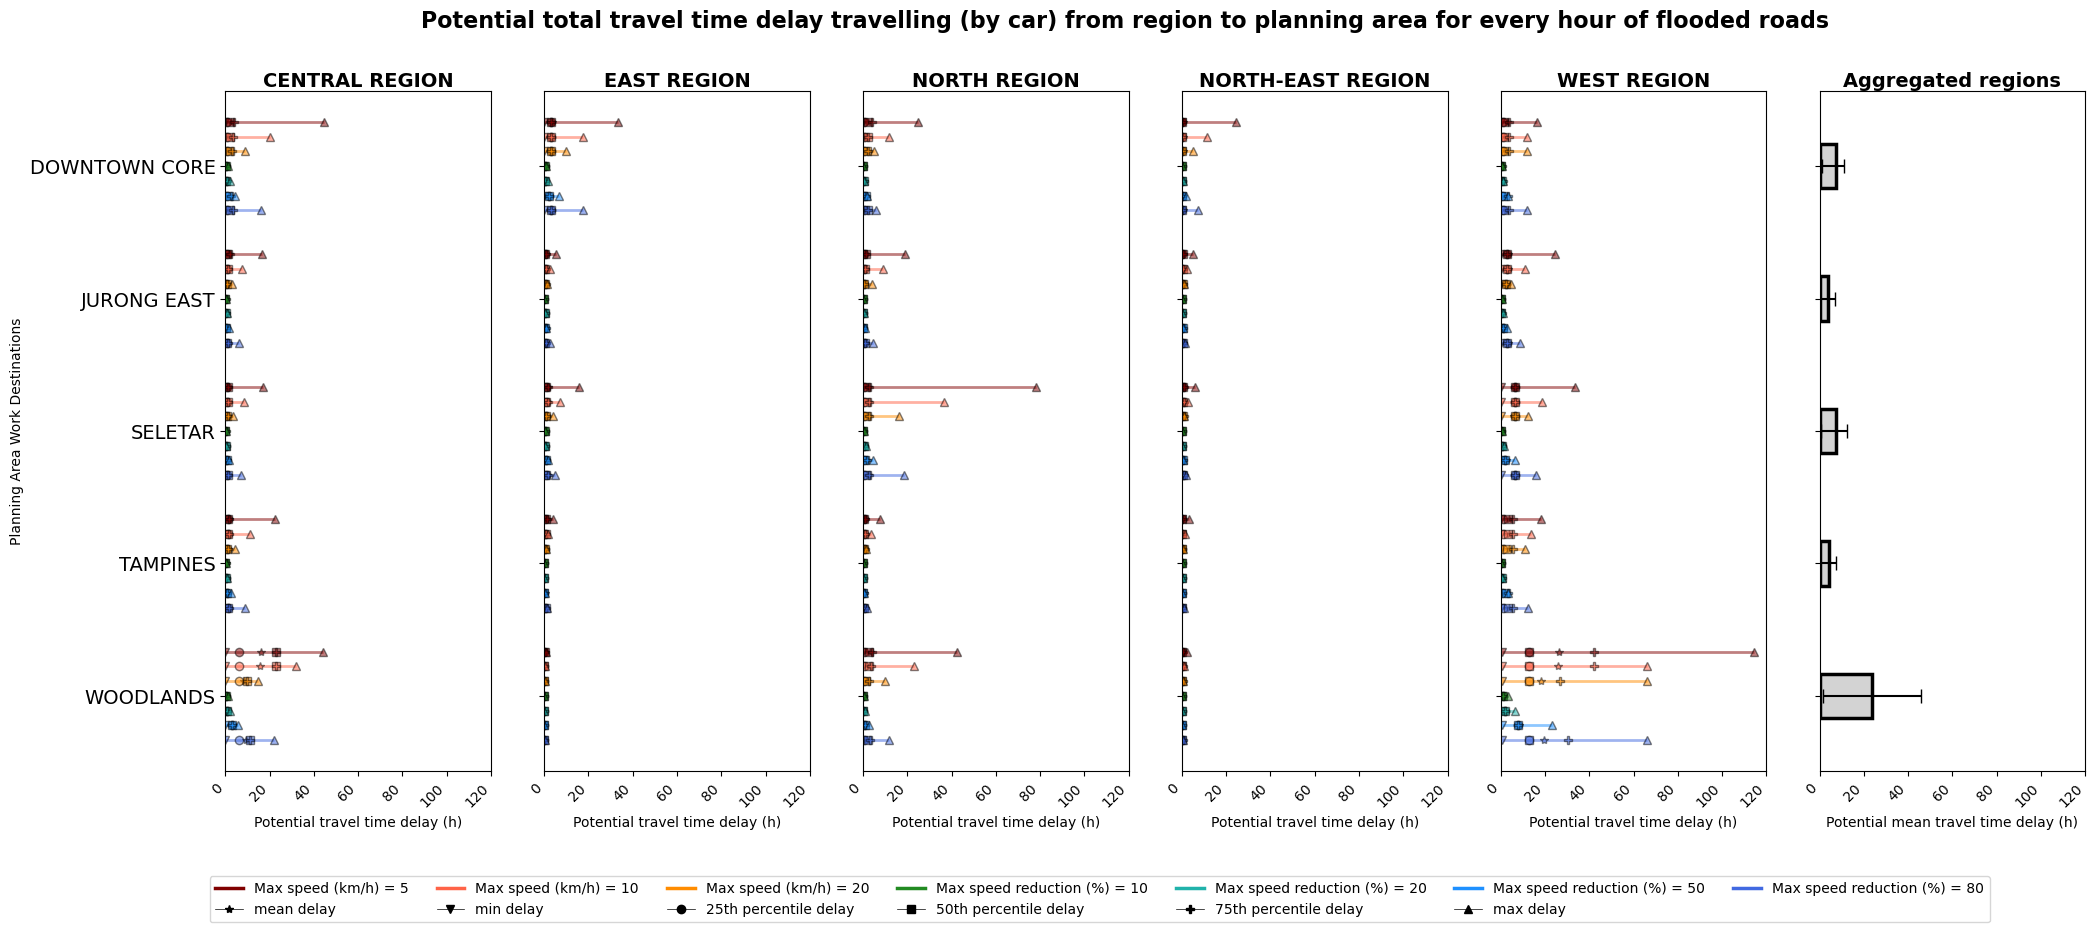

In [ ]:
selected_planningArea=['TAMPINES','JURONG EAST','WOODLANDS','DOWNTOWN CORE','SELETAR']
save_dir = r"data\floodRouting"
transport_mode = "car"
flooded_fps = floodedRouting.fetch_data(save_dir=save_dir,transport_mode=transport_mode,routing=True, stats=True)
if transport_mode == "car":
    # get itineraries
    dry_df = pd.read_csv(r"data\car_routing_osmnx_planningArea.csv")
elif transport_mode == "bus":
    dry_df = pd.read_csv(r"data\bus_routing_OneMap_planningArea.csv")

print(flooded_fps['routing'])

save_dir = r"data\floodRouting"

PTTD = floodedRouting.PlotTravelTimeDelay(flood_routing_fps=flooded_fps['routing'],
                    dry_routing_fp=r"data\car_routing_osmnx_planningArea.csv",
                    flood_stats_fps=flooded_fps['stats'],
                    planningArea=planningArea_shp,
                    units="hours",
                    selected_planningArea=selected_planningArea)
car_potential_time_delay = PTTD.get_potential_car_time_delay(maxTrafficVol)
car_time_delay_sum = PTTD.get_time_delay_sum(car_potential_time_delay, var = "mean")
# save plot
save_fp = os.path.join(save_dir,"car_TotalTimeDelay.png")
PTTD.plot_potential_time_delay(car_potential_time_delay,car_time_delay_sum,
                               title="Potential total travel time delay travelling (by car) from region to planning area for every hour of flooded roads",
                               loc=(0.1,0.03),title_fontsize=16,axis_fontsize=14,
                               save_fp=None)

# Bus

['data\\floodRouting\\bus_routing_rfTypehighest 60 min rainfall (mm)_rfPerc99.9_maxspeed10.csv', 'data\\floodRouting\\bus_routing_rfTypehighest 60 min rainfall (mm)_rfPerc99.9_maxspeed20.csv', 'data\\floodRouting\\bus_routing_rfTypehighest 60 min rainfall (mm)_rfPerc99.9_maxspeed5.csv', 'data\\floodRouting\\bus_routing_rfTypehighest 60 min rainfall (mm)_rfPerc99.9_percReducMaxspeed10.csv', 'data\\floodRouting\\bus_routing_rfTypehighest 60 min rainfall (mm)_rfPerc99.9_percReducMaxspeed20.csv', 'data\\floodRouting\\bus_routing_rfTypehighest 60 min rainfall (mm)_rfPerc99.9_percReducMaxspeed50.csv', 'data\\floodRouting\\bus_routing_rfTypehighest 60 min rainfall (mm)_rfPerc99.9_percReducMaxspeed80.csv']
maxspeed10
maxspeed20
maxspeed5
percReducMaxspeed10
percReducMaxspeed20
percReducMaxspeed50
percReducMaxspeed80


C:\Users\hypak\AppData\Local\Temp\ipykernel_1280\3010051792.py:93: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



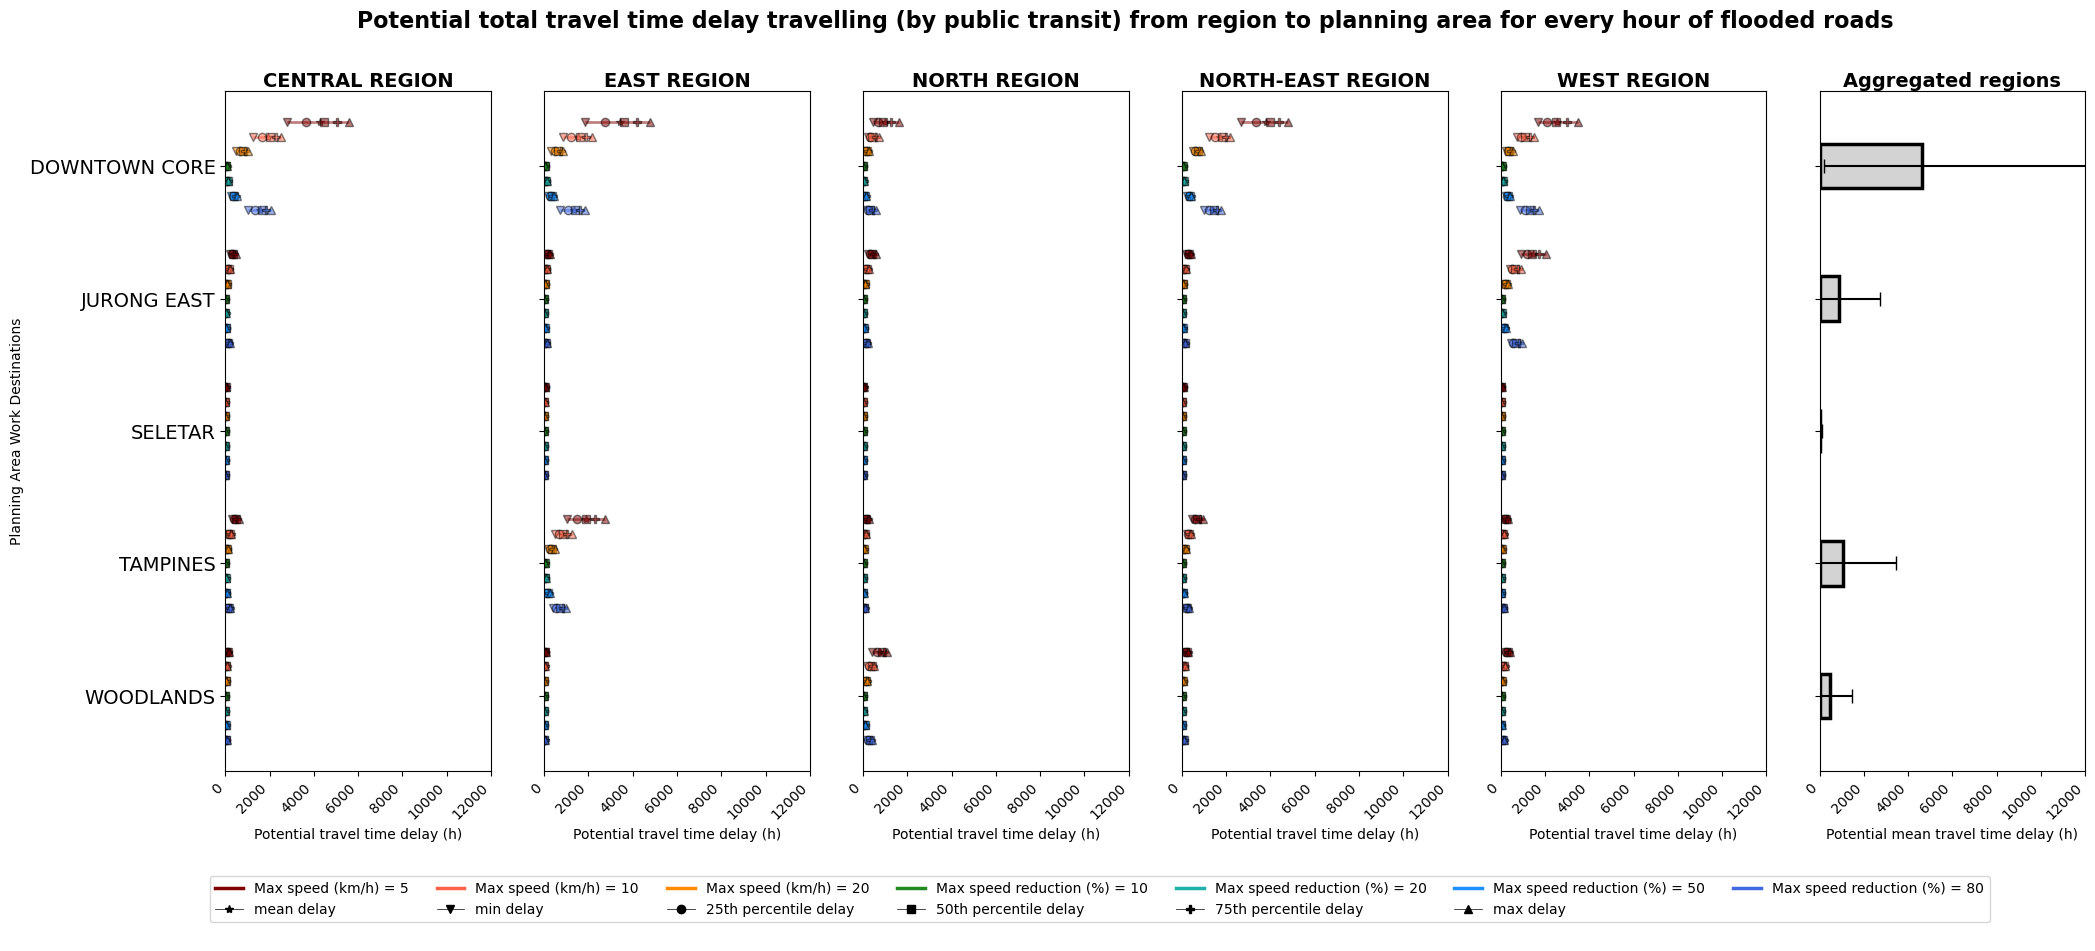

In [ ]:
selected_planningArea=['TAMPINES','JURONG EAST','WOODLANDS','DOWNTOWN CORE','SELETAR']
save_dir = r"data\floodRouting"
transport_mode = "bus"
flooded_fps = floodedRouting.fetch_data(save_dir=save_dir,transport_mode=transport_mode,routing=True, stats=True)
if transport_mode == "car":
    # get itineraries
    dry_df = pd.read_csv(r"data\car_routing_osmnx_planningArea.csv")
elif transport_mode == "bus":
    dry_df = pd.read_csv(r"data\bus_routing_OneMap_planningArea.csv")

print(flooded_fps['routing'])

save_dir = r"data\floodRouting"
# flooded_df = pd.read_csv(flooded_fps['routing'][0])
# TTD = floodedRouting.TravelTimeDelay(flooded_df,dry_df,planningArea_shp,
#                                             column_value="simulated_total_duration",
#                                             end_groupby='end_PLN_AREA_N',
#                                             start_groupby='start_REGION_N')

# # compute travel time delay by comparing the difference in dry_df and flooded_df
# travel_time_delay_df = TTD.compute_travel_time_delay()
# # print("Length of travel time delay df: ", len(travel_time_delay_df))
# potential_time_delay = TTD.get_potential_publicTransit_time_delay(OD_hourly_avg, spatialTravelPatterns, travel_time_delay_df)

PTTD = floodedRouting.PlotTravelTimeDelay(flood_routing_fps=flooded_fps['routing'],
                    dry_routing_fp=r"data\bus_routing_OneMap_planningArea.csv",
                    flood_stats_fps=flooded_fps['stats'],
                    units="hours",
                    planningArea=planningArea_shp,
                    selected_planningArea=selected_planningArea)
bus_potential_time_delay = PTTD.get_potential_publicTransit_time_delay(OD_hourly_avg,spatialTravelPatterns)
bus_time_delay_sum = PTTD.get_time_delay_sum(bus_potential_time_delay, var = "mean")
# save plot
save_fp = os.path.join(save_dir,"bus_TotalTimeDelay.png")
PTTD.plot_potential_time_delay(bus_potential_time_delay,bus_time_delay_sum,
                               title="Potential total travel time delay travelling (by public transit) from region to planning area for every hour of flooded roads",
                               loc=(0.1,0.03),title_fontsize=16,axis_fontsize=14,
                               save_fp=None)

In [11]:
import plotly.graph_objects as go

def travelSankey(spatialTravelPatterns,planningArea,height=600, width=800, save_fp=None):
    """   
    Args:
        spatialTravelPatternns (pd.DataFrame): df that shows the mode of transport from region to planning area
        planningArea (gpd.GeoDataFrame): df that shows that planning area and corresponding region
        height (float): in px
        width (float): in px
        save_fp (str): filepath to save to
    """
    # filter other columns in spatial travel patterns e.g. work from home
    spatialTravelPatterns = spatialTravelPatterns[spatialTravelPatterns['end_PLN_AREA_N'].isin(planningArea['PLN_AREA_N'].to_list())]
    melt_df = spatialTravelPatterns[['end_PLN_AREA_N','start_REGION_N','Combinations of MRT/LRT or Public Bus','Car/Taxi/Private Hire Car Only']].rename(columns={'Combinations of MRT/LRT or Public Bus':'Public Transit','Car/Taxi/Private Hire Car Only':'Car'}).melt(id_vars=['end_PLN_AREA_N','start_REGION_N'],var_name="Transport Mode",value_name="Volume")
    # map colours to region
    colors = {'EAST REGION':"#dffeb2","WEST REGION": "#ffe7c8","CENTRAL REGION":"#bedcfd",
                    'NORTH REGION':"#e9b3fd",'NORTH-EAST REGION':"#fdb3ba",
                    }
    # map colours of region and plan area to colors of region
    planningArea['colors'] = planningArea['REGION_N'].apply(lambda x: colors[x])
    # assign different colours for 
    categories = ['start_REGION_N','Transport Mode', 'end_PLN_AREA_N']
    # Sankey will flow from start region to transport, then flow from transport to plan area
    newDf = pd.DataFrame()
    for i in range(len(categories)-1):
        tempDf = melt_df[[categories[i],categories[i+1],'Volume']]
        tempDf.columns = ['source','target','count']
        newDf = pd.concat([newDf,tempDf])    
    newDf = newDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
    # sort by count
    # newDf = newDf.sort_values(by=['count','source','target'],ascending=False)
    color_mappings = dict()
    for entry in planningArea[['PLN_AREA_N','REGION_N','colors']].to_dict(orient='records'): # returns a list of dict
        color_mappings[entry['PLN_AREA_N']] = entry['colors']
        color_mappings[entry['REGION_N']] = entry['colors']
    color_mappings['Public Transit'] = "#42f551"
    color_mappings['Car'] = "#999999"

    label_list = list(np.unique(melt_df[categories].values))
    color_list = [color_mappings[l] for l in label_list]
    # elements of source and target are the indexes of label_list
    source = newDf['source'].apply(lambda x: label_list.index(x))
    target = newDf['target'].apply(lambda x: label_list.index(x))
    count = newDf['count']
    # plot sankey
    fig = go.Figure(data=[go.Sankey(
        node = {"label": label_list, "color": color_list},
        link = {"source": source, "target": target, "value": count,"arrowlen":15}
        )])
    fig.update_layout(autosize=False,
        width=width, height=height,
        margin=dict(l = 50, r = 50, b= 50, t = 50, pad = 2))
    if save_fp is not None:
        fig.write_image(save_fp)
    else:
        fig.show()
    
    return 

save_dir = r"data\floodRouting"
save_fp = os.path.join(save_dir,"spatialTravelPatterns_sankey.png")
travelSankey(spatialTravelPatterns,planningArea_shp, 
             width=800,height=800,
             save_fp=None)